<div class="alert alert-block alert-info">
<b>Note:</b> The goal of this notebook is to show you how to work with the Bayesian Statistics Toolbox (BST) when approaching linear regression analyses. It also introduces multi-level (hierarchical) modeling. This is an adaptation of Jordi Warmenhoven's PyMC3 port of Chapter 17 of John Kruschke's textbook "Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan" (https://github.com/JWarmenhoven/DBDA-python). Please note that the code has been updated to make use of PyMC4 and that this does not (yet) include all of the examples from the original. </div>

### Table of Contents:
- [Robust linear regression](#Robust-linear-regression)
- [Hierarchical regression on individuals within groups](#Hierarchical-regression-on-individuals-within-groups)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
import src.bayesian_stats as bst

from IPython.display import Image

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

In [3]:
def plot_cred_lines(dist, x, sd_x, sd_y, mean_x, mean_y, ax):
    """This function plots credibility lines."""
    # Convert parameters to original scale
    beta0 = dist[:, 0]
    beta1 = dist[:, 1]
    B = pd.DataFrame(np.c_[beta0, beta1], columns=['beta0', 'beta1'])

    # Credible regression lines from posterior
    hpd_interval = np.round(az.hdi(B.values, hdi_prob=0.95), decimals=3)
    B_hpd = B[B.beta0.between(*hpd_interval[0, :]) & B.beta1.between(*hpd_interval[1, :])] 
    xrange = np.arange(x.min()*.95, x.max()*1.05)
    for i in np.random.randint(0, len(B_hpd), 30):
        ax.plot(xrange, B_hpd.iloc[i, 0] + B_hpd.iloc[i, 1]*xrange, c='b', alpha=.6, zorder=0) 
        

### Robust linear regression

#### Graphical model 

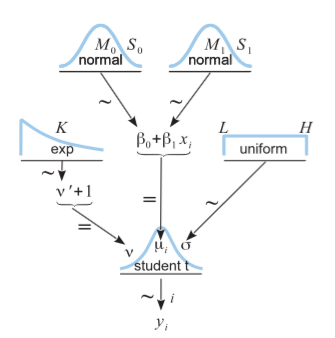

In [4]:
Image('images/fig17_2.png', width=400)

In [5]:
df_n30 = pd.read_csv('data/HtWtData30.csv')
df_n30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    30 non-null     int64  
 1   height  30 non-null     float64
 2   weight  30 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 848.0 bytes


In [6]:
df_n30.head()

male  height  weight
0     0    64.0   136.4
1     0    62.3   215.1
2     1    67.9   173.6
3     0    64.2   117.3
4     0    64.8   123.3

In [7]:
# Call your Bayesian Statistics Toolbox (BST) function
model, idata = bst.robust_linear_regression(df_n30["height"], df_n30["weight"], n_draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0, zbeta1, sigma, nu_minus_one]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 22 seconds.


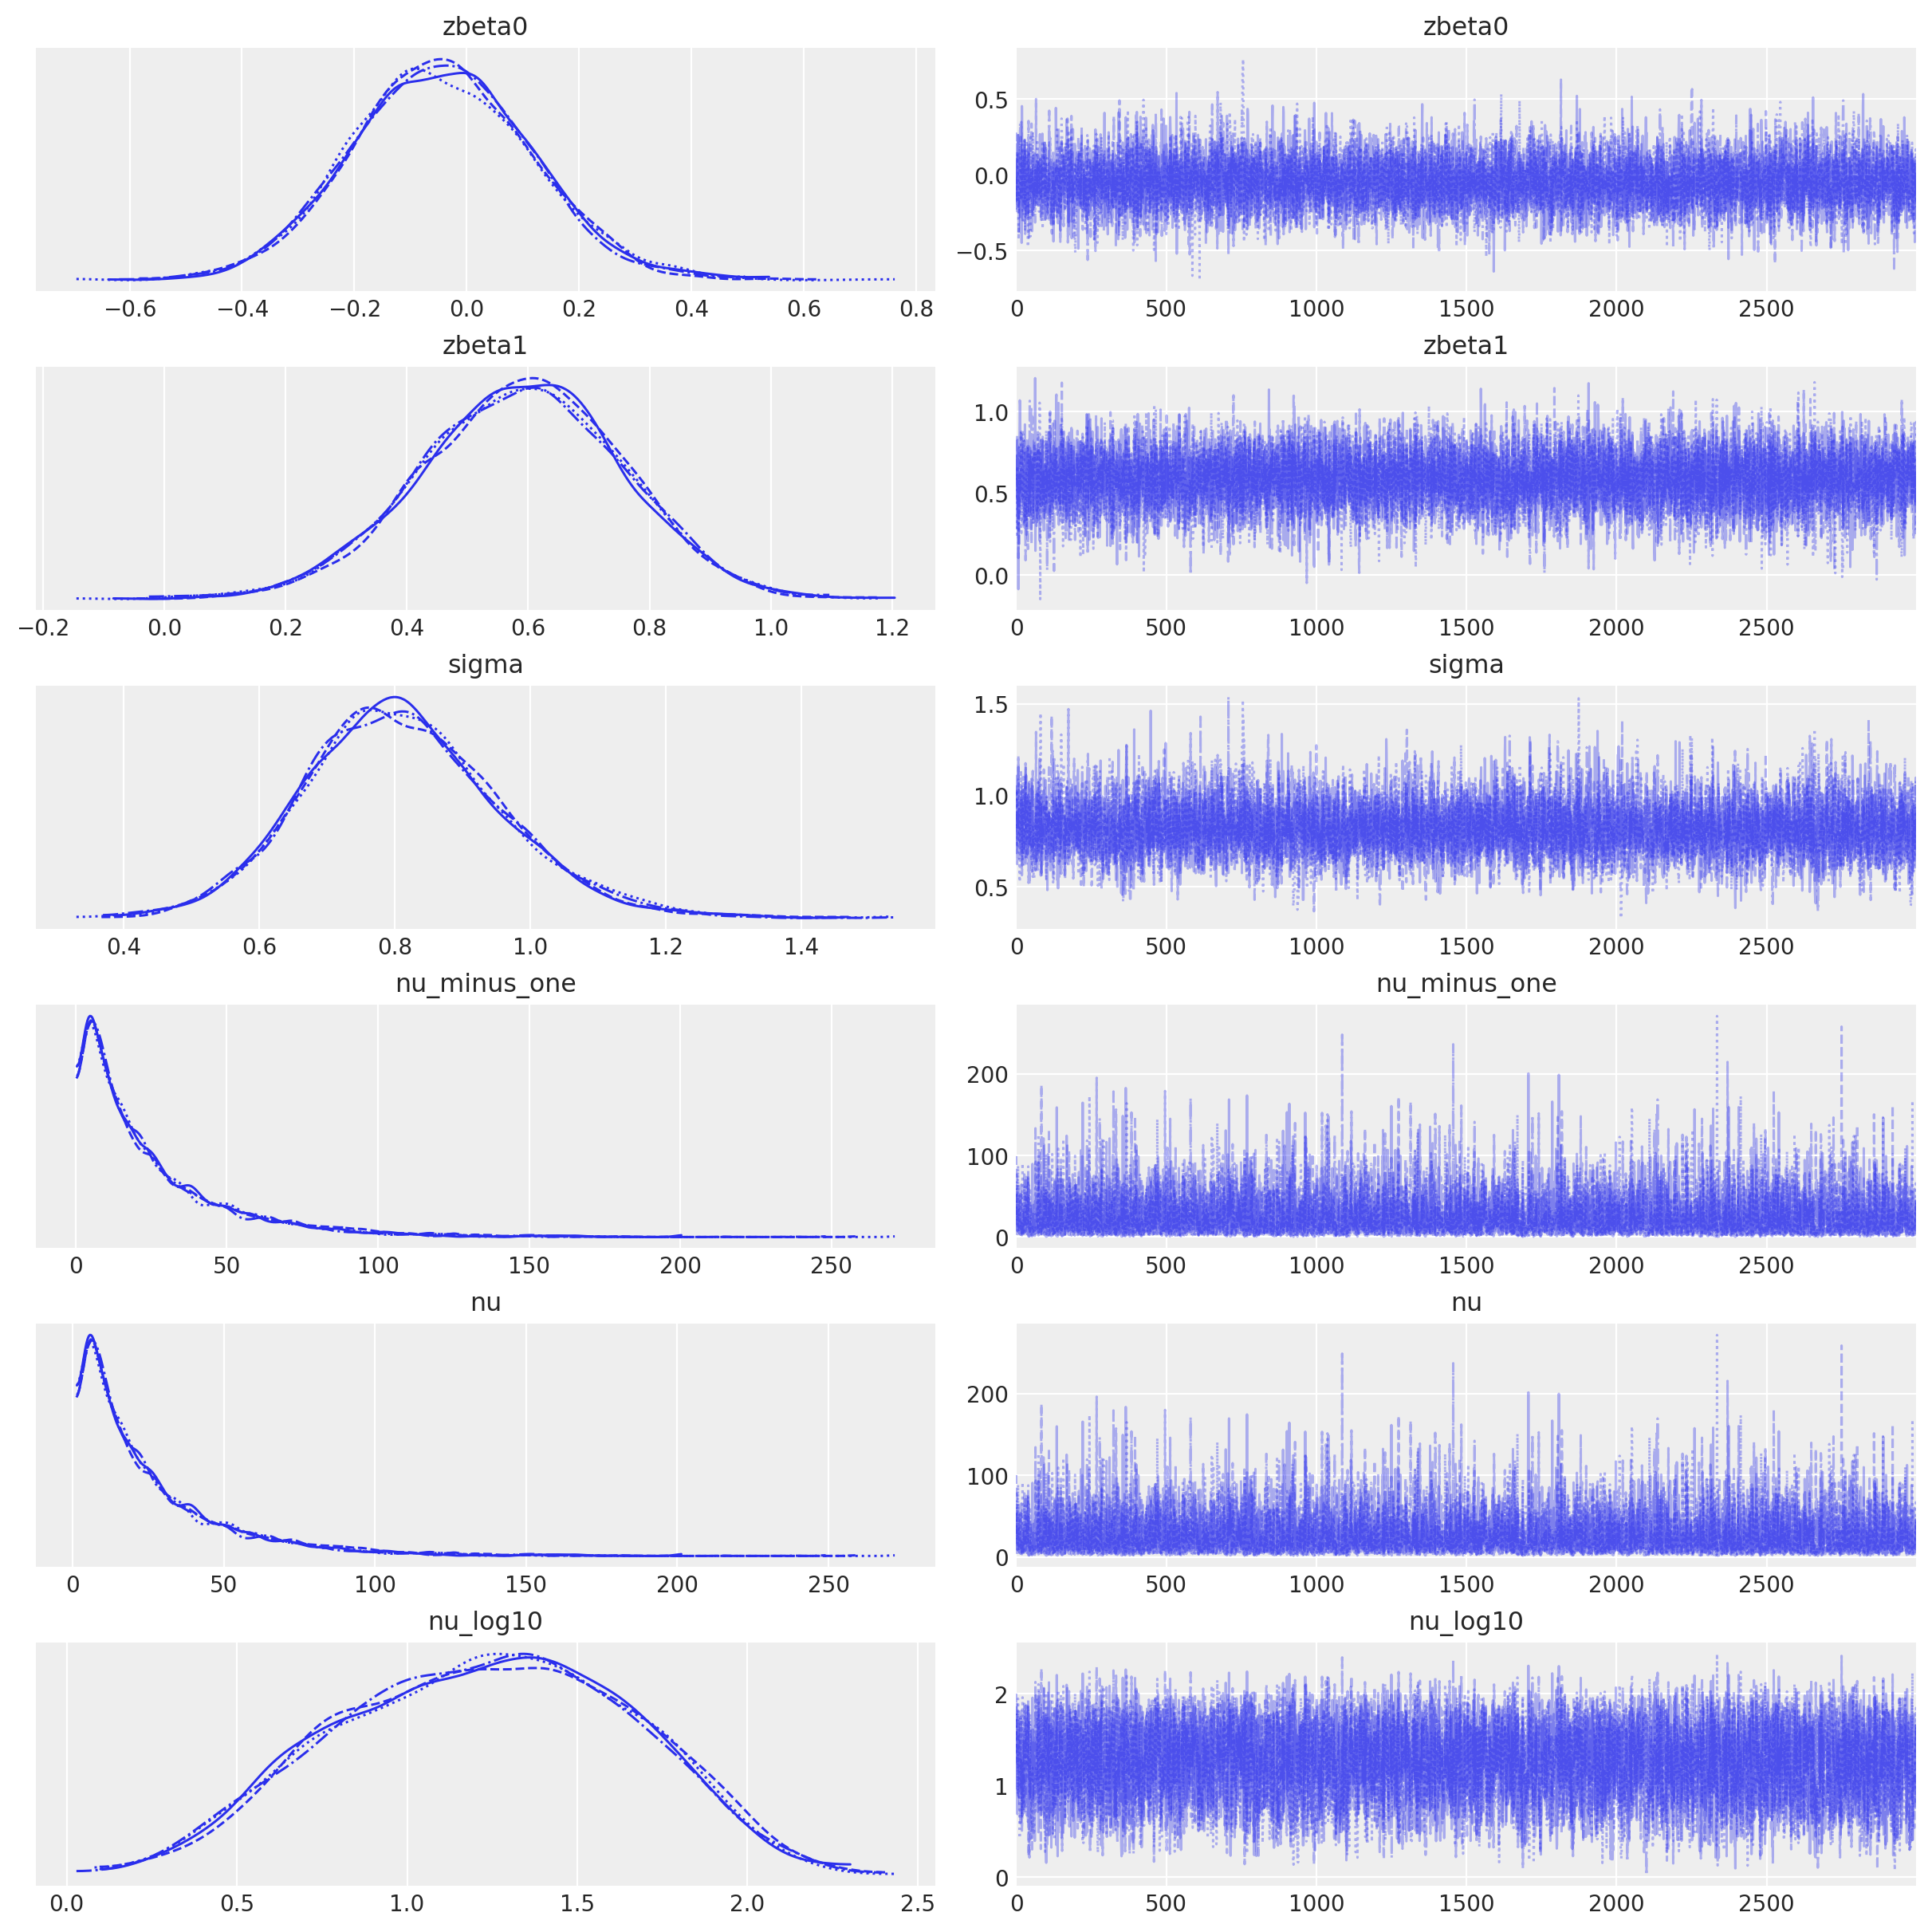

In [8]:
pm.plot_trace(idata);

In [9]:
# Combine chains
post = az.extract(idata.posterior)

In [10]:
# One extra step: Convert standardized coefficients back to raw scale 
post["beta0"], post["beta"], post["sigma"] = bst.unstandardize_linreg_parameters(
    post["zbeta0"], post["zbeta1"], post["sigma"], df_n30["height"], df_n30["weight"])

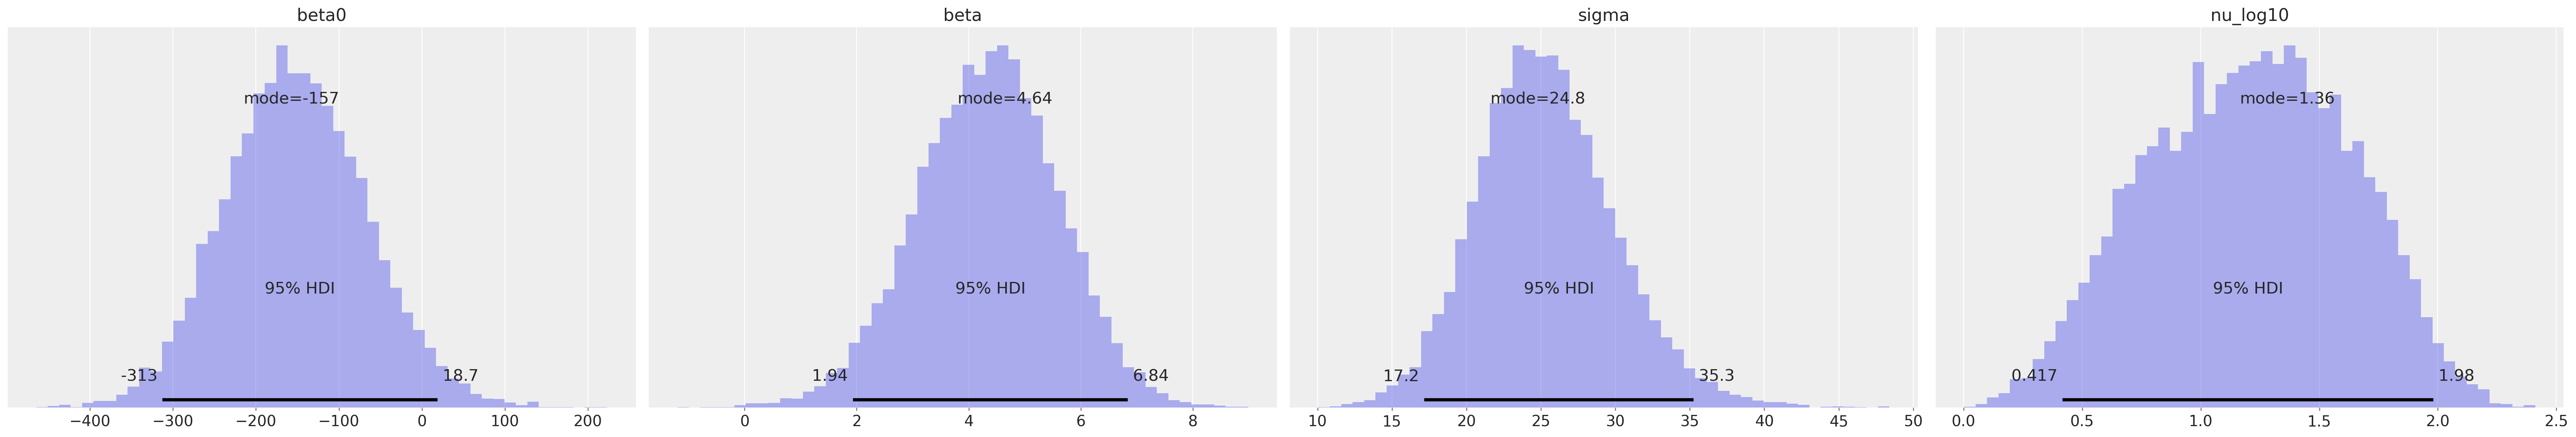

In [11]:
az.plot_posterior(post, combine_dims={"sample"}, 
                  var_names=["beta0", "beta", "sigma", "nu_log10"],
                  kind="hist",
                  bins=50,
                  point_estimate="mode", 
                  round_to=3
                 );

### Hierarchical regression on individuals within groups

#### Graphical model

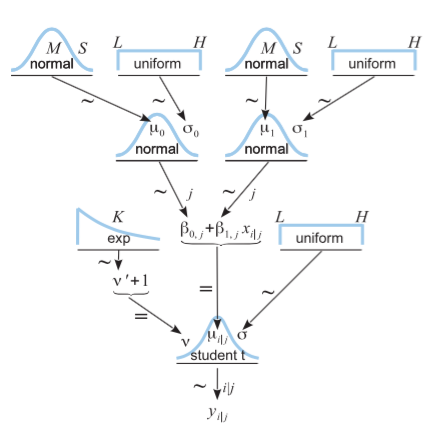

In [12]:
Image('images/fig17_6.png', width=500)

In [13]:
df_HRegr = pd.read_csv('data/HierLinRegressData.csv')
df_HRegr.Subj = df_HRegr.Subj.astype('category')
df_HRegr.Subj = df_HRegr.Subj.cat.as_ordered()
df_HRegr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Subj    132 non-null    category
 1   X       132 non-null    float64 
 2   Y       132 non-null    float64 
dtypes: category(1), float64(2)
memory usage: 3.1 KB


In [14]:
df_HRegr.head()

Subj     X      Y
0    1  60.2  145.6
1    1  61.5  157.3
2    1  61.7  165.6
3    1  62.3  158.8
4    1  67.6  196.1

In [15]:
# Call your Bayesian Statistics Toolbox (BST) function
model2, idata2 = bst.hierarchical_regression(df_HRegr.X, df_HRegr.Y, df_HRegr.Subj, acceptance_rate=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0, zbeta1, zsigma0, zsigma1, zbeta0_s_offset, zbeta1_s_offset, zsigma, nu_minus_one]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


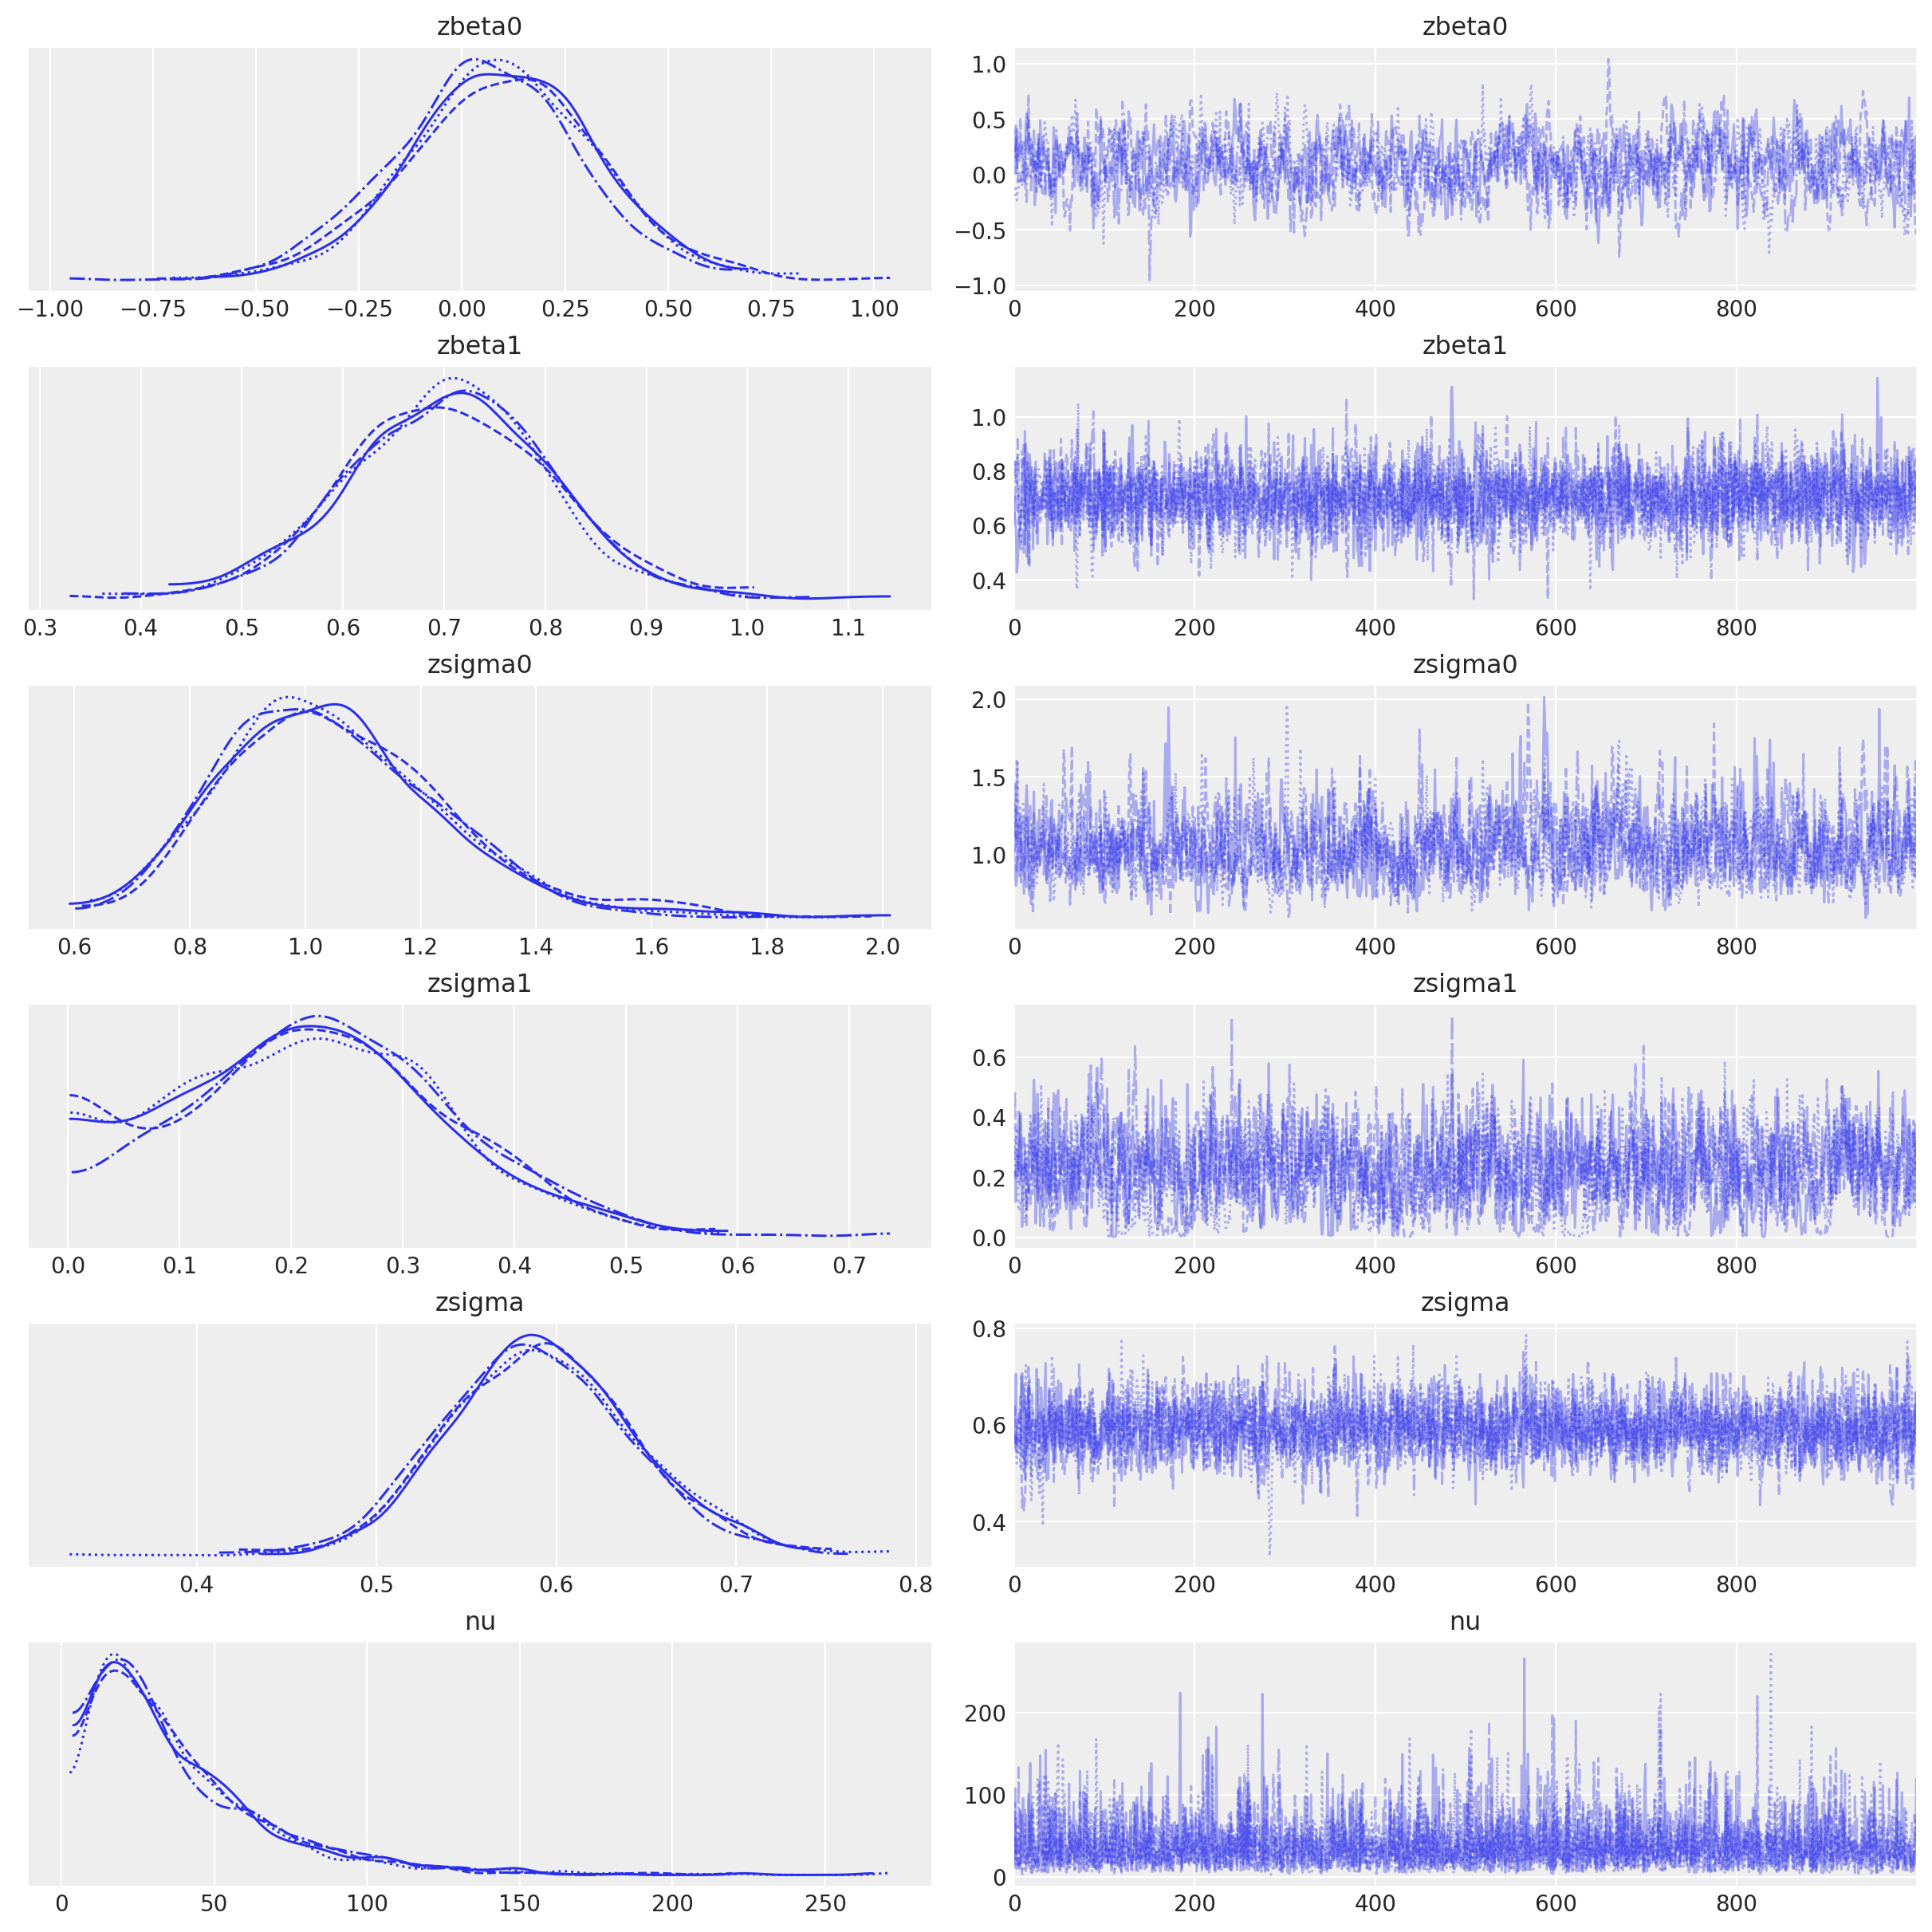

In [16]:
az.plot_trace(idata2, var_names=["zbeta0", "zbeta1", "zsigma0", "zsigma1", "zsigma", "nu"]);

In [17]:
# Stack posterior samples from all chains
post = az.extract(idata2.posterior)

# One extra step: Convert standardized coefficients back to raw scale 
post["beta0"], post["beta1"], post["sigma"] = bst.unstandardize_linreg_parameters(post["zbeta0"], 
                                                                                  post["zbeta1"], 
                                                                                  post["zsigma"], 
                                                                                  df_HRegr.X, df_HRegr.Y)

post["beta0_s"], post["beta1_s"], _ = bst.unstandardize_linreg_parameters(post["zbeta0_s"], 
                                                                          post["zbeta1_s"], 
                                                                          post["zsigma"],
                                                                          df_HRegr.X, df_HRegr.Y)

/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_799/225623024.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd_interval = np.round(az.hdi(B.values, hdi_prob=0.95), decimals=3)


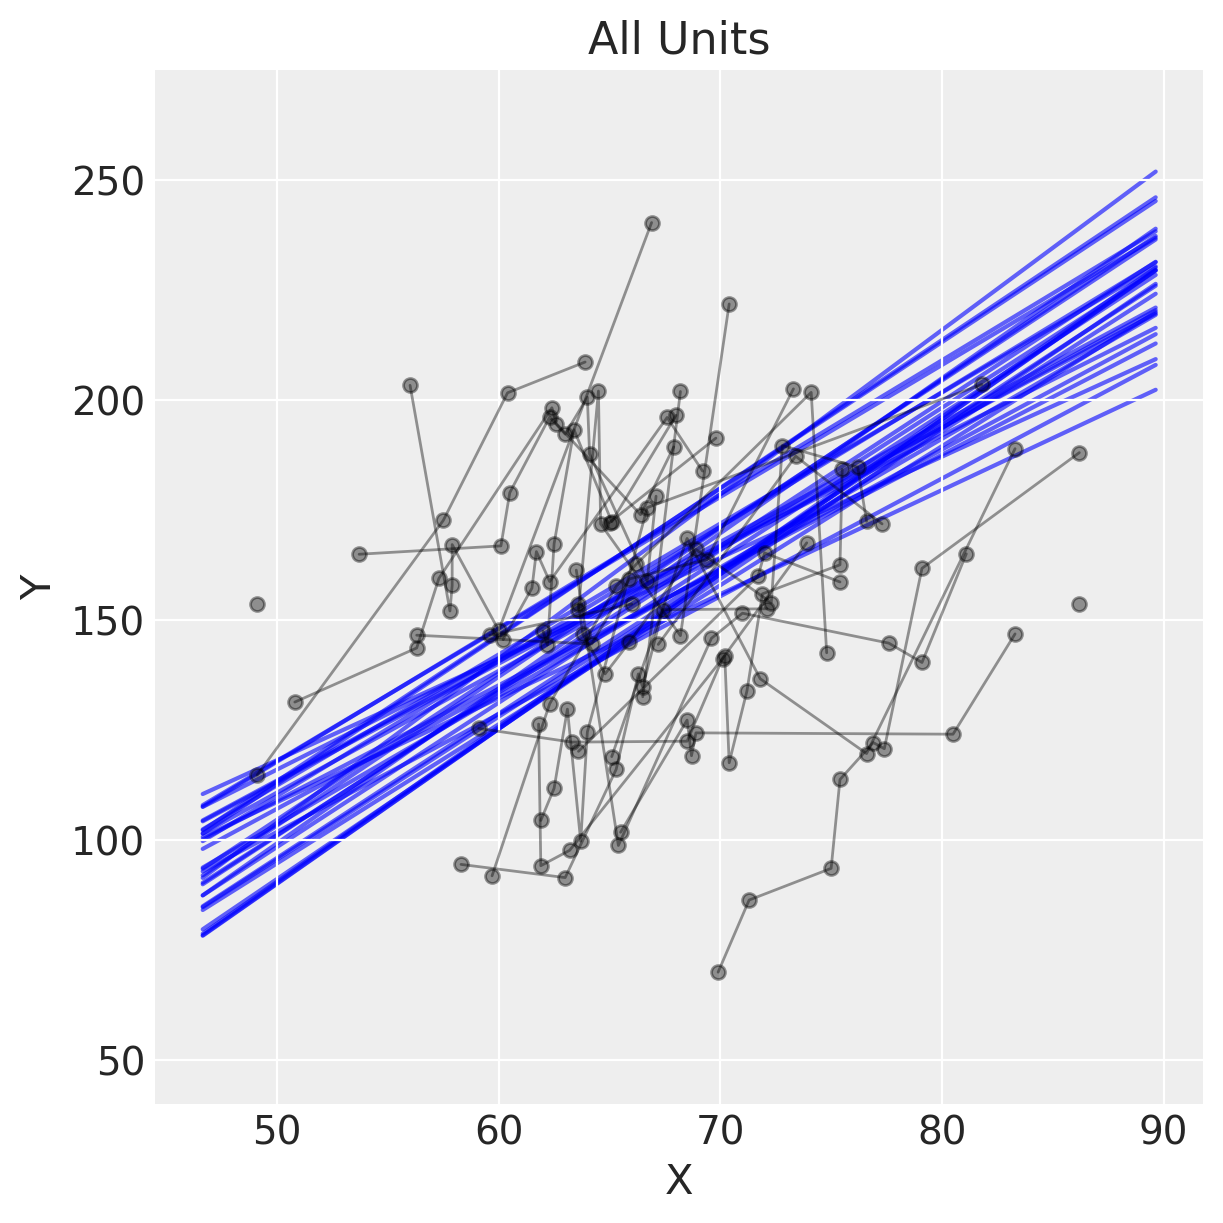

In [18]:
# Plot credible group-level regression lines with data from all individuals
plt.figure(figsize=(6,6))
ax = plt.gca()

df_HRegr.groupby('Subj').apply(lambda group: ax.plot(group.X, group.Y, 'k-o', lw=1, markersize=5, alpha=.4))
ax.set(xlabel='X', ylabel='Y', ylim=(40, 275), title='All Units');

plot_cred_lines(np.c_[post['beta0'], post['beta1']], df_HRegr.X, df_HRegr.X.std(), 
                df_HRegr.Y.std(), df_HRegr.X.mean(), df_HRegr.Y.mean(), ax)

/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_799/225623024.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd_interval = np.round(az.hdi(B.values, hdi_prob=0.95), decimals=3)
/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_799/225623024.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd_interval = np.round(az.hdi(B.values, hdi_prob=0.95), decimals=3)
/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_799/225623024.py:9: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpd_interval = np.round(az.hdi(B.values, hdi_prob=0.95), decimals=3)
/var/folders/42/fy648srd41l966jbjlswhljc0000gn/T/ipykernel_799/225623024.py:

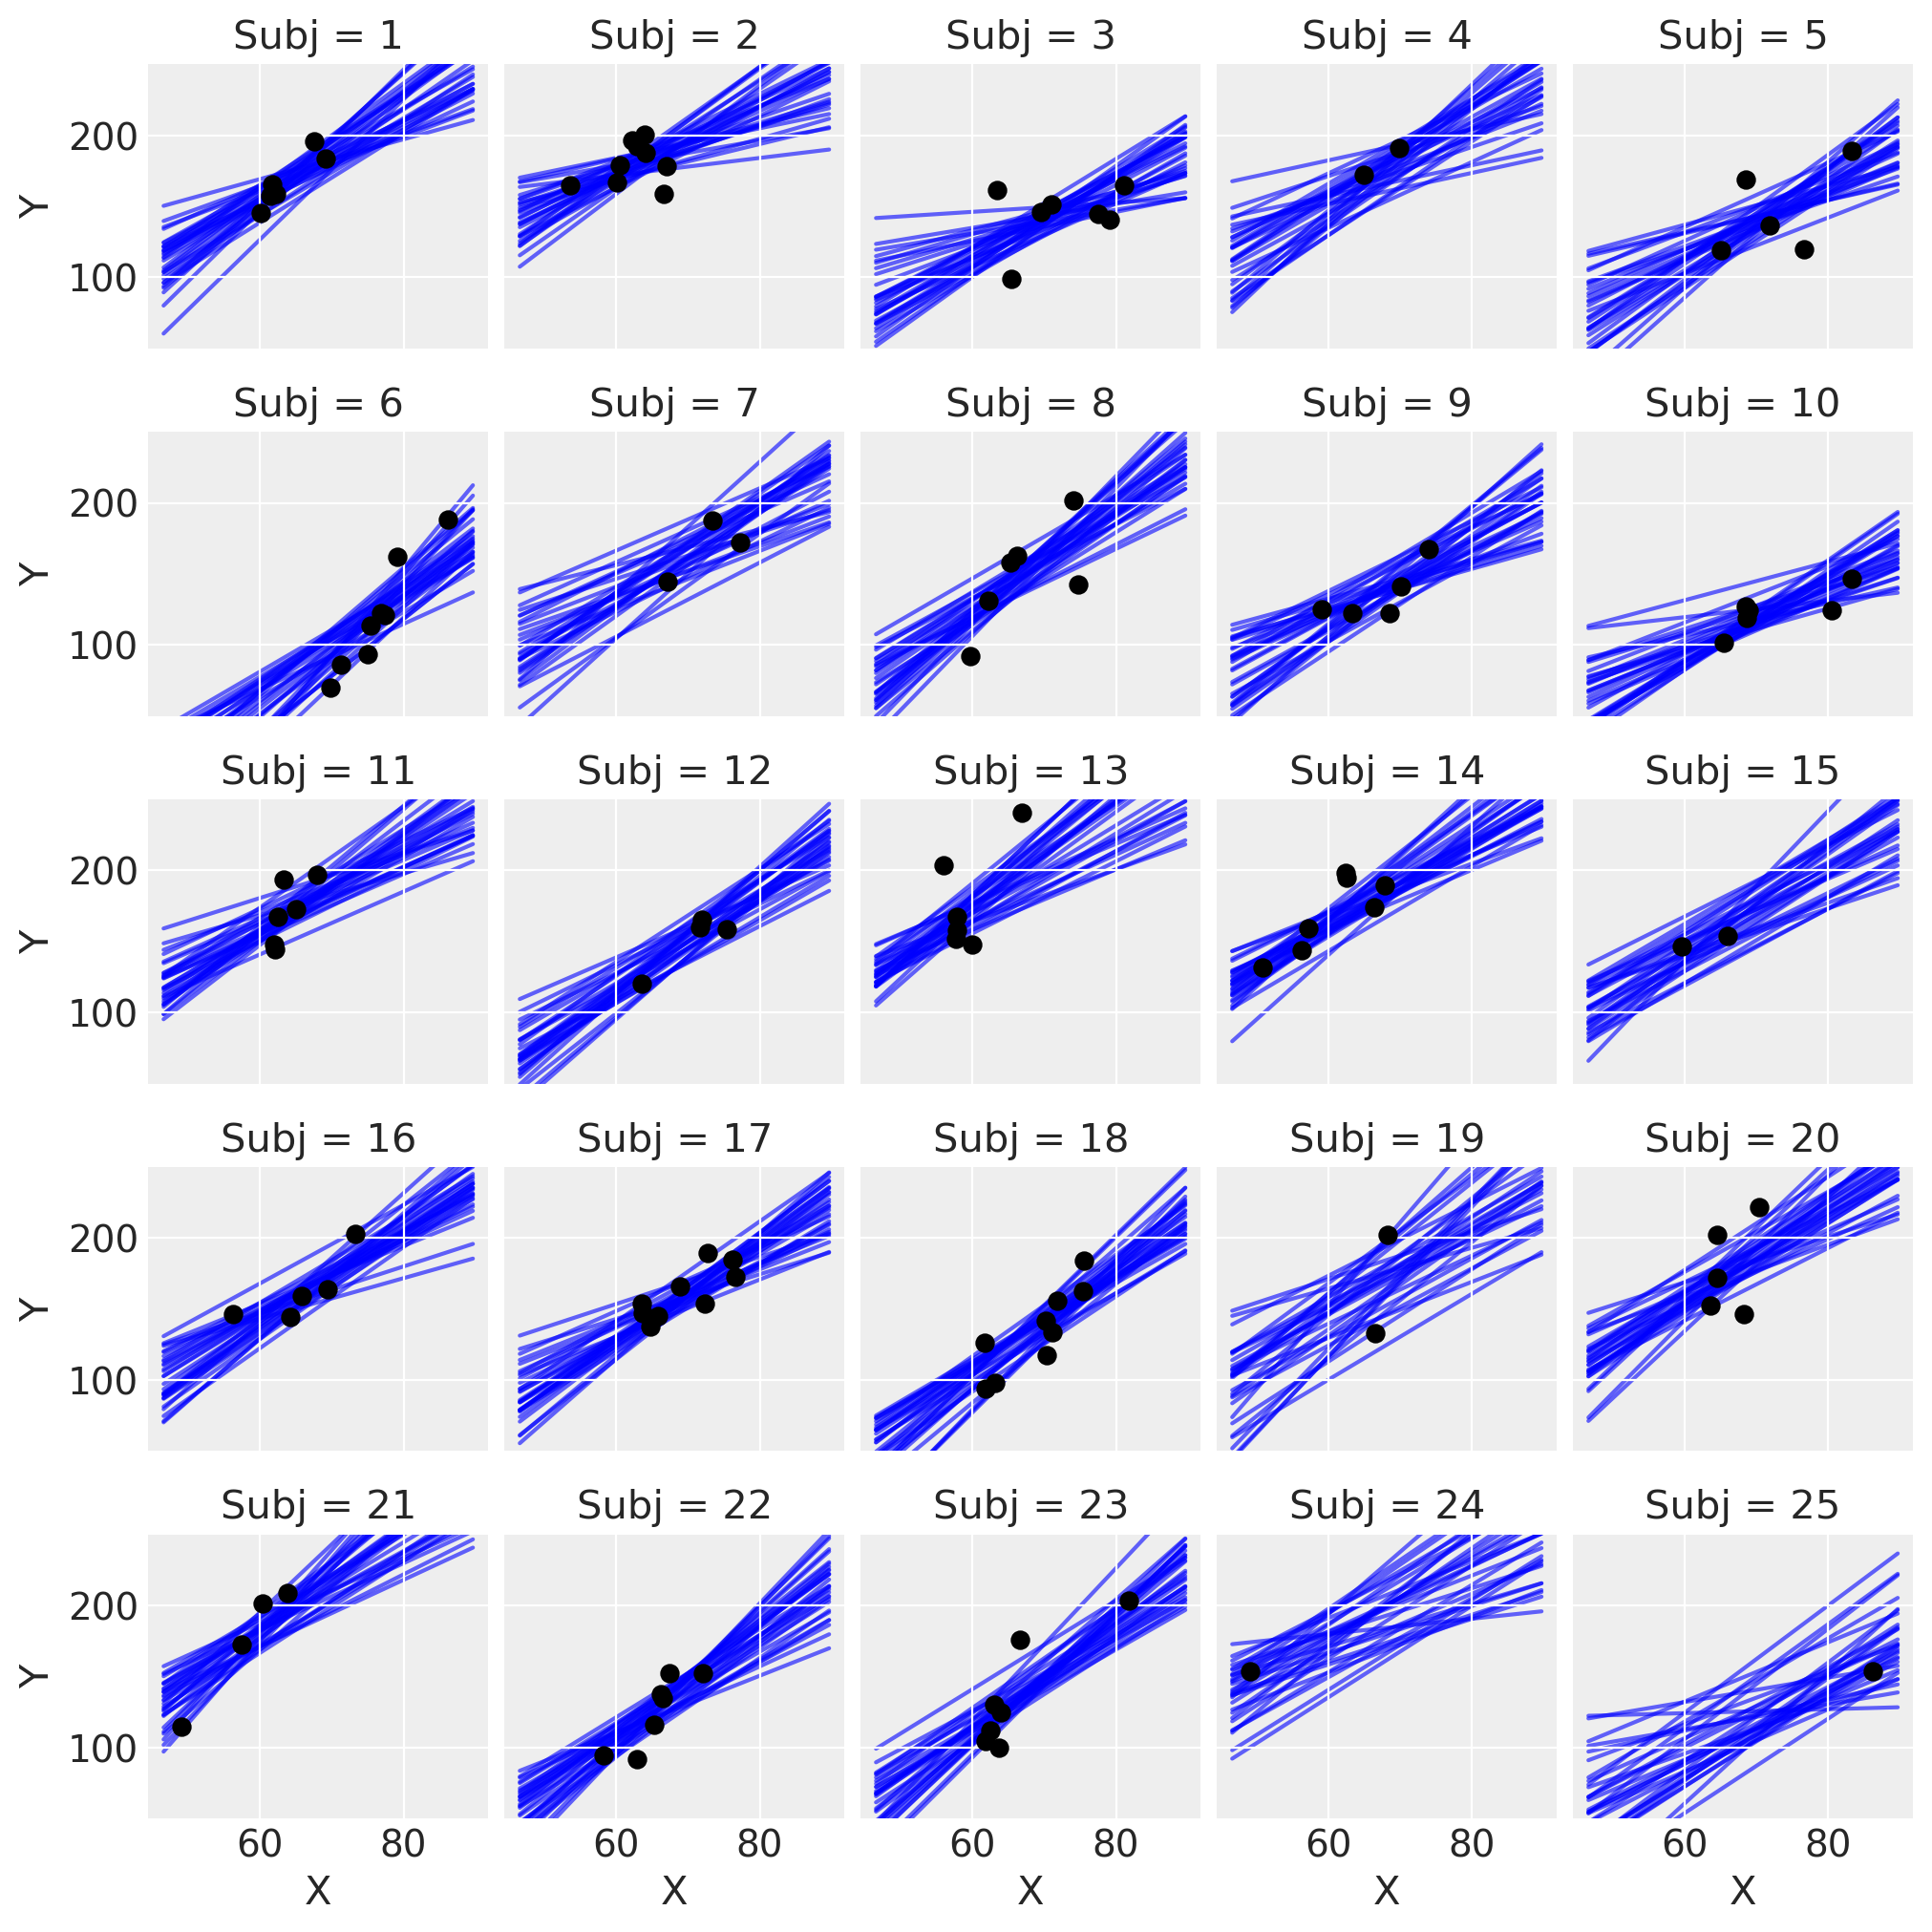

In [19]:
# Plot credible subject-level regression lines for all individuals
fg = sns.FacetGrid(df_HRegr, col='Subj', col_wrap=5, ylim=(50,250), height=2)
fg.map(plt.scatter, 'X', 'Y', color='k', s=40)

for i, ax in enumerate(fg.axes):
    plot_cred_lines(np.c_[post['beta0_s'][i, :], post['beta1_s'][i, :]],
                    df_HRegr.X, df_HRegr.X.std(), df_HRegr.Y.std(), 
                    df_HRegr.X.mean(), df_HRegr.Y.mean(), ax);